# Imports

In [26]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Initialize Dataset

In [27]:
image_path = []
labels = []

for i in os.listdir("/kaggle/input/animal-faces/afhq"):
  for label in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/kaggle/input/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/kaggle/input/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])
data_df.head()

,image_path,labels
0,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
1,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog
2,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
3,/kaggle/input/animal-faces/afhq/val/dog/flickr...,dog
4,/kaggle/input/animal-faces/afhq/val/dog/pixaba...,dog


In [28]:
#############
# Data Split
#############
train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index)

val = test.sample(frac=0.5, random_state=42)
test = test.drop(val.index)

# Preprocessing

In [29]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

# Transform all images into one clear format (preprocess all images to same properties)
# training
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

# test and val
transform2 = transforms.Compose([
  transforms.Resize((128, 128)),
  transforms.ToTensor(),
  transforms.ConvertImageDtype(torch.float)
])

# Custom Dataset Class

In [30]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels']))

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(img_path).convert('RGB')

    if self.transform:
      image = self.transform(image)

    return image, label

In [31]:
#########################
# Create Dataset Objects
#########################
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform2)
test_dataset = CustomImageDataset(dataframe=test, transform=transform2)

# Visualize Images

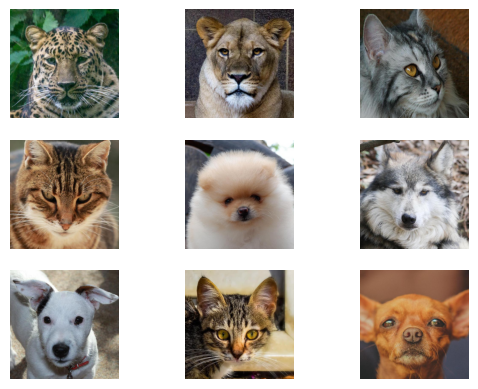

In [32]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

In [33]:
##################
# Hyperparameters
##################
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

# DataLoaders

In [34]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [39]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.bn3 = nn.BatchNorm2d(128)
    
    self.pooling = nn.MaxPool2d(2, 2)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    
    self.flatten = nn.Flatten()
    self.linear = nn.Linear((128*16*16), 128)
    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.pooling(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.pooling(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)
    x = self.pooling(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.output(x)

    return x

model = Net().to(device)

In [40]:
################
# Model Summary
################
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
         MaxPool2d-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
      BatchNorm2d-10          [-1, 128, 32, 32]             256
             ReLU-11          [-1, 128, 32, 32]               0
        MaxPool2d-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

In [42]:
####################
#Loss and Optimizer
####################
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4)

# Training

In [43]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_acc_val = 0
  total_loss_val = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
      
    optimizer.zero_grad()
    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  with torch.no_grad():
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      outputs = model(inputs)
      val_loss = criterion(outputs, labels)
      total_loss_val += val_loss.item()

      val_acc = (torch.argmax(outputs, axis=1) == labels).sum().item()
      total_acc_val += val_acc

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_loss_validation_plot.append(round(total_loss_val/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  total_acc_validation_plot.append(round(total_acc_val/(val_dataset.__len__())*100, 4))

  print(f'''Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%
              Validation Loss: {round(total_loss_val/100, 4)} Validation Accuracy: {round((total_acc_val)/val_dataset.__len__() * 100, 4)}%''')
  print("="*60)


Epoch 1/10, Train Loss: 3.1645 Train Accuracy 82.0565%
              Validation Loss: 0.353 Validation Accuracy: 91.4463%
Epoch 2/10, Train Loss: 1.5413 Train Accuracy 92.2505%
              Validation Loss: 0.2357 Validation Accuracy: 94.5868%
Epoch 3/10, Train Loss: 1.1721 Train Accuracy 94.1635%
              Validation Loss: 0.2132 Validation Accuracy: 95.4959%
Epoch 4/10, Train Loss: 0.9756 Train Accuracy 94.9252%
              Validation Loss: 0.2341 Validation Accuracy: 94.1322%
Epoch 5/10, Train Loss: 0.8904 Train Accuracy 95.6603%
              Validation Loss: 0.1679 Validation Accuracy: 95.8678%
Epoch 6/10, Train Loss: 0.7854 Train Accuracy 95.9348%
              Validation Loss: 0.1935 Validation Accuracy: 95.5372%
Epoch 7/10, Train Loss: 0.7315 Train Accuracy 96.2271%
              Validation Loss: 0.1686 Validation Accuracy: 96.8182%
Epoch 8/10, Train Loss: 0.6977 Train Accuracy 96.4574%
              Validation Loss: 0.1495 Validation Accuracy: 96.6942%
Epoch 9/10, Train

# Testing

In [44]:
with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
      
    predictions = model(inputs)

    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()
    test_acc = (torch.argmax(predictions, axis=1) == labels).sum().item()
    total_acc_test += test_acc

print(f"Accuracy Score is: {round(total_acc_test/test_dataset.__len__() * 100, 4)} and Loss is: {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.1141 and Loss is: 0.0173


# Plotting Training Progress

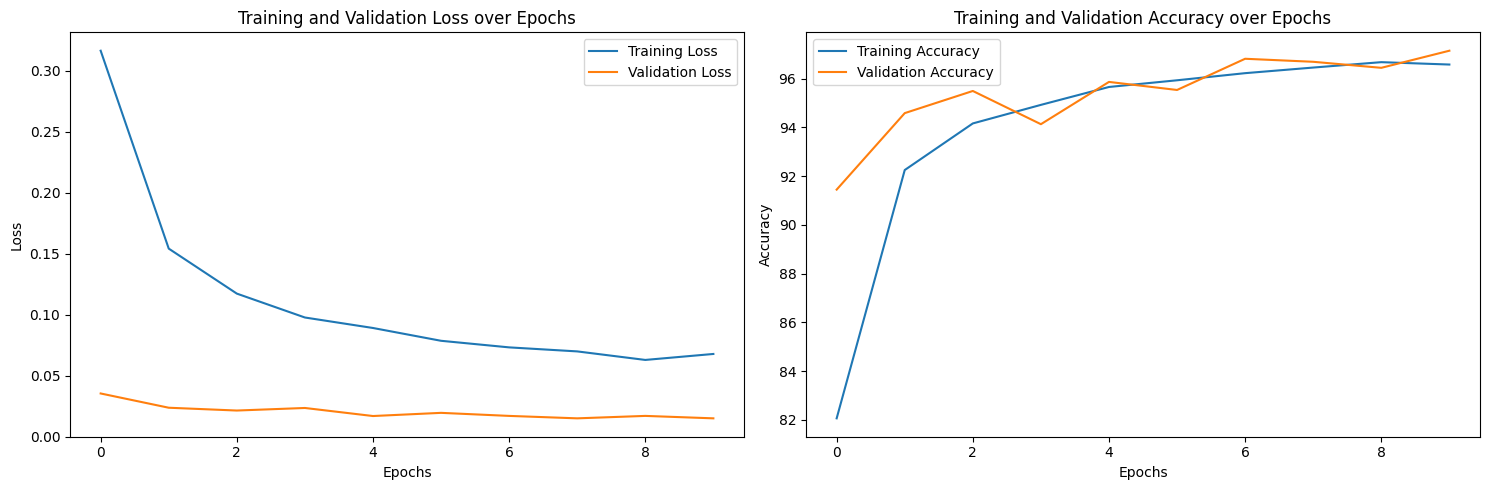

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

# Inference

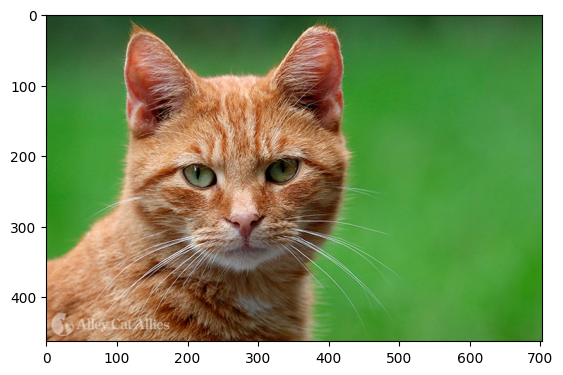


Prediction: 



'cat'

In [55]:
########################################
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder
########################################

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform2(image).unsqueeze(0).to(device)

  output = model(image)
  pred = torch.argmax(output, axis=1).item()
  return label_encoder.inverse_transform([pred])[0]

# Visualize the Image
image = Image.open('/kaggle/input/animal-photos/FELV-cat.jpg')
plt.imshow(image)
plt.show()

# Predict
print()
print('Prediction: \n')
predict_image('/kaggle/input/animal-photos/FELV-cat.jpg')